In [1]:
library(tidyverse)
library(targets)
library(Seurat)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   0.3.4
✔ tibble  3.2.1     ✔ dplyr   1.1.2
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.2     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect




In [35]:
source('../01_milo/milo.R')

In [ ]:
tar_deps('deg_Oligodendrocytes___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none')

In [ ]:
manifest = tar_manifest(fields = NULL)

In [ ]:
manifest %>% filter(name == 'deg_Oligodendrocytes___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_rest')

In [118]:
obj = qs::qread('_targets/objects/obj_Day5.Oligodendrocytes')
nhgc = qs::qread('_targets/objects/nhgc_Oligodendrocytes___Day5.obob5v5__v__Day5.obobBL6d5')
obj

An object of class Seurat 
12973 features across 1095 samples within 2 assays 
Active assay: integrated (2000 features, 2000 variable features)
 2 layers present: data, scale.data
 1 other assay present: RNA
 2 dimensional reductions calculated: pca, umap

In [193]:
grouping_col = 'fgf1_grouping'
group_a = 'pos'
group_b = 'none'
tag = 'Oligodendrocytes___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none'

nhgc['grouping'] = nhgc[grouping_col]
    group_a = stringr::str_split(group_a, pattern=fixed('.')) %>% unlist
    cells_a = nhgc %>%
        filter(grouping %in% group_a) %>%
        pull(rowname)
    if (group_b == ''){
        group_b = nhgc %>%
            filter(!(grouping %in% group_a)) %>%
            pull(grouping) %>%
            as.character %>%
            unique %>%
            paste0(collapse='.')
    }
    group_b = stringr::str_split(group_b, pattern=fixed('.')) %>% unlist
    cells_b = nhgc %>%
        filter(grouping %in% group_b) %>%
        pull(rowname)

In [5]:
expr_matrix = obj %>% GetAssayData(assay='RNA', layer = 'counts')
expressed_cells_count = rowSums(expr_matrix > 0)
expr_frac = 0.10
expr_ct = expr_matrix %>% dim %>% `[`(2) %>% `*`(expr_frac)
features_in_n_cells <- names(expressed_cells_count[expressed_cells_count >= expr_ct])
selected_features = features_in_n_cells %>% #only if not running variablefeatures
    enframe %>% 
    select(value) %>% 
    filter(!str_detect(value, 'Gm|Rik')) %>%
    pull(value) 

In [ ]:
get_seurat_nhg_markers_negbinom = function(seurat_obj, nhgc, grouping_col, group_a, group_b='', tag=''){
    nhgc['grouping'] = nhgc[grouping_col]
    group_a = stringr::str_split(group_a, pattern=fixed('.')) %>% unlist
    cells_a = nhgc %>%
        filter(grouping %in% group_a) %>%
        pull(rowname)
    if (group_b == ''){
        group_b = nhgc %>%
            filter(!(grouping %in% group_a)) %>%
            pull(grouping) %>%
            as.character %>%
            unique %>%
            paste0(collapse='.')
    }
    group_b = stringr::str_split(group_b, pattern=fixed('.')) %>% unlist
    cells_b = nhgc %>%
        filter(grouping %in% group_b) %>%
        pull(rowname)

    expr_matrix = seurat_obj %>% GetAssayData(assay='RNA', layer = 'counts')
    expressed_cells_count = rowSums(expr_matrix > 0)
    expr_frac = 0.90
    expr_ct = expr_matrix %>% dim %>% `[`(2) %>% `*`(expr_frac)
    features_in_n_cells <- names(expressed_cells_count[expressed_cells_count >= expr_ct])
    selected_features = features_in_n_cells %>% #only if not running variablefeatures
        enframe %>% 
        select(value) %>% 
        filter(!str_detect(value, '^Gm|^Rik|^mt')) %>%
        pull(value) 

    markers = Seurat::FindMarkers(seurat_obj, ident.1=cells_a, ident.2=cells_b, assay='RNA', slot="counts", verbose=TRUE,
                                  min.cells.group = 10, 
                                  min.cells.feature = 10,
                                  min.pct = 0.01,
                                  logfc.threshold = 0,
                                  test.use='negbinom',
                                  latent.vars= c('hash.mcl.ID', 'batch'),
                                  features=selected_features,
                                  only.pos = FALSE) 
    markers['tag'] = tag
    markers
}

In [ ]:
markers = get_seurat_nhg_markers_negbinom(obj, nhgc, grouping_col, group_a, group_b=group_b, tag='')

In [194]:
    expr_matrix = obj %>% GetAssayData(assay='RNA', layer = 'counts')
    expressed_cells_count = rowSums(expr_matrix > 0)
    expr_frac = 0.10
    expr_ct = expr_matrix %>% dim %>% `[`(2) %>% `*`(expr_frac)
    features_in_n_cells <- names(expressed_cells_count[expressed_cells_count >= expr_ct])
    selected_features = features_in_n_cells %>% #only if not running variablefeatures
        enframe %>% 
        select(value) %>% 
        filter(!str_detect(value, '^Gm|^Rik|^mt')) %>%
        pull(value) 
#     selected_features = Features(obj@assays$integrated) %>% intersect(selected_features)
# selected_features = features_in_n_cells %>% #only if not running variablefeatures
#         enframe %>% 
#         select(value) %>% 
#         filter(!str_detect(value, '^Gm|^Rik|^mt')) %>%
#         pull(value) 

In [195]:
selected_features = Features(obj@assays$integrated) %>% intersect(selected_features) 

In [196]:
selected_features

[1] "Nrxn1"         "Lsamp"         "Nnat"          "9330111N05Rik"
  [5] "Tnik"          "Fry"           "Luzp2"         "Sparcl1"      
  [9] "Adgrb3"        "Msi2"          "Pcdh7"         "Kirrel3"      
 [13] "Synpr"         "Mir99ahg"      "Ctnnd2"        "Fam214a"      
 [17] "Pbx1"          "Man1a"         "Nckap5"        "Adgrl3"       
 [21] "Adgrv1"        "Zfpm2"         "A230057D06Rik" "Pde4d"        
 [25] "Tenm2"         "Cadm2"         "Chsy3"         "Hdac8"        
 [29] "Cntn1"         "Grm7"          "4930445B16Rik" "Dcc"          
 [33] "Map2"          "Nfasc"         "Lrmda"         "Itsn2"        
 [37] "Slc7a15"       "Macf1"         "Fhit"          "Pcdh17"       
 [41] "Ahcyl1"        "Pik3r3"        "Slc1a3"        "Kcnma1"       
 [45] "Frmd4a"        "Nav3"          "Ralyl"         "Maml2"        
 [49] "Negr1"         "Rims2"         "Mical3"        "Wwox"         
 [53] "Fgf12"         "Macrod2"       "Mgat5"         "Nlgn1"        
 [57] "Plpp3"         "Slc13a1"       "Kctd16"        "Dmd"          
 [61] "Gas7"          "Opcml"         "Npas3"         "Cacnb4"       
 [65] "Gria4"         "Ccser1"        "Gria2"         "Mdga2"        
 [69] "Agmo"          "Syne1"         "Atxn1"         "Robo1"        
 [73] "Akt3"          "Cadm1"         "Ctnna2"        "Csmd2"        
 [77] "6330403K07Rik" "Arhgap5"       "Cdh8"          "Glp2r"        
 [81] "Apoe"          "Prickle1"      "Ank3"          "Immp2l"       
 [85] "Tmeff2"        "Rfx3"          "Meg3"          "Ptgds"        
 [89] "Fam13c"        "Kcnq1ot1"      "Pcdh11x"       "9330175M20Rik"
 [93] "Shroom3"       "Pacrg"         "Spock1"        "2210408I21Rik"
 [97] "Sybu"          "Srgap3"        "Psd3"          "1700111E14Rik"
[101] "Anks1b"        "Lrrc4c"        "Scmh1"         "Ggact"        
[105] "Tmem132d"      "Nav2"          "Naaladl2"      "Sgip1"        
[109] "Lama2"         "Chd9"          "Ablim2"        "C730002L08Rik"
[113] "Ust"           "Nr3c2"         "Large1"        "Dtna"         
[117] "Pex5l"         "Filip1l"       "Syn3"          "Setbp1"       
[121] "Xkr4"          "Auts2"         "Acsl3"         "Tmem163"      
[125] "Enah"          "Cr2"           "March1"        "Peg3"         
[129] "5033421B08Rik" "5830418P13Rik" "Pcdh9"         "Gab2"         
[133] "Garem1"        "Cdh20"         "Ssbp2"         "4930419G24Rik"
[137] "Cpq"           "Pcyt2"         "Slc22a23"      "Cdh10"        
[141] "Spock3"        "Cadps"         "Asap1"         "Dusp15"       
[145] "4930444A19Rik" "Rnf220"        "Slc24a3"       "Smyd3"        
[149] "St3gal4"       "Ahcyl2"        "5330434G04Rik" "Iqch"         
[153] "Zc3h12b"       "Xrcc4"         "Sytl2"         "4930420G21Rik"
[157] "Pbx3"          "Unc5c"         "Eml1"          "Cradd"        
[161] "Sertad2"       "Trps1"         "Pclo"          "Hivep2"       
[165] "1700042O10Rik" "Igf2bp3"       "Iqck"          "Antxr1"       
[169] "Ncam2"         "Sycp2"         "Pak7"          "Pcdh15"       
[173] "Adipor2"       "Jakmip2"       "Dpyd"          "Il1rapl1"     
[177] "Nav1"          "Rps6ka3"       "9330199G10Rik" "Cux1"         
[181] "Lrrtm3"        "Pdgfc"         "Ccser2"        "Grid2"        
[185] "C130071C03Rik" "Pde1c"         "Erbb4"         "9930021J03Rik"
[189] "B430010I23Rik" "Cask"          "Plekha1"       "Grik2"        
[193] "Adcy10"        "Il33"          "Prtg"          "Sorcs3"       
[197] "Pam"           "R3hdm1"        "Bfsp2"         "A330015K06Rik"
[201] "Lrrc4"         "Kcnab1"        "Slc8a3"        "8030451O07Rik"
[205] "Magi1"         "Lcorl"         "Ppfia2"        "Ube2e2"       
[209] "Phf21a"        "Prrg1"         "Alcam"         "Mbd5"         
[213] "Elovl6"        "Cd180"         "Rasal2"        "Hcn2"         
[217] "Stard13"       "Gtdc1"         "Abtb2"         "Mob3b"        
[221] "A230001M10Rik" "Ubr5"          "Mrtfb"         "Sh3gl3"       
[225] "Nfib"          "Anln"          "Nxpe4"         "Pkd2l1"       
[229] "Ephb1

In [197]:
DefaultAssay(obj) = 'integrated'
markers = Seurat::FindMarkers(obj, ident.1=cells_a, ident.2=cells_b, slot="data", verbose=TRUE,
                              min.cells.group = 10, 
                              min.cells.feature = 50,
                              min.pct = 0.01,
                              logfc.threshold = 0,
                              test.use='MAST',
                              latent.vars=c('hash.mcl.ID'),
                              features = selected_features,
                              only.pos = FALSE) 


Done!

Combining coefficients and standard errors

Calculating log-fold changes

Calculating likelihood ratio tests

Refitting on reduced model...


Done!



In [198]:
markers %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0) %>% rownames %>% length

[1] 9

In [199]:
markers %>% filter(p_val_adj < 0.05) %>% rownames %>% length

[1] 34

In [200]:
markers = markers %>% add_gsea_cols_to_seurat_marker_results 

Joining with `by = join_by(GeneID)`


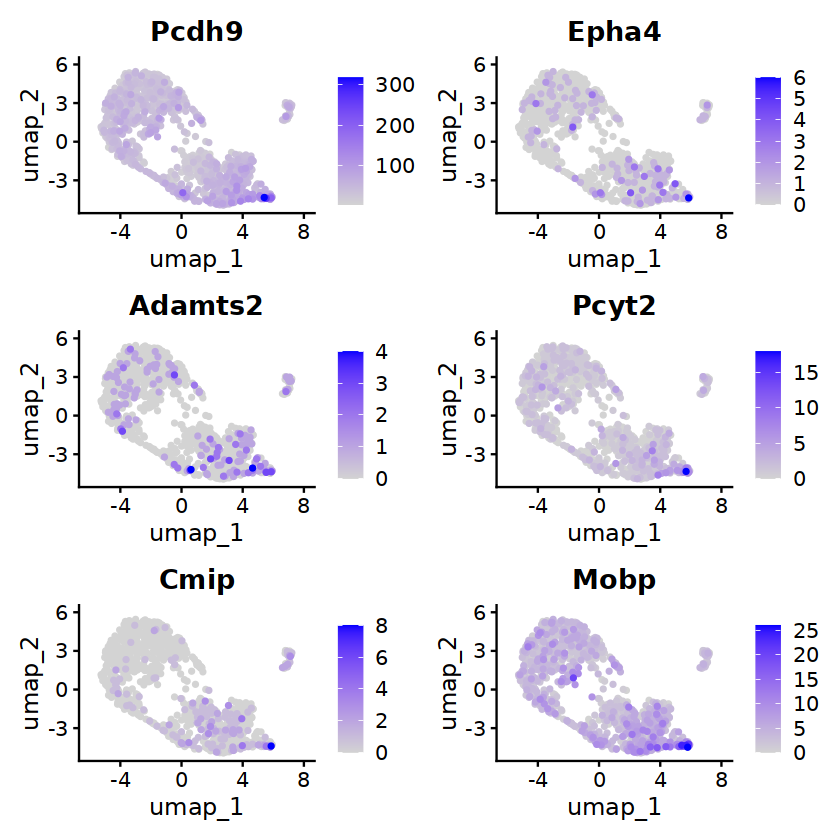

In [201]:
FeaturePlot(obj %>% { DefaultAssay(.) <- 'RNA'; . } ,slot = 'counts', features = markers %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0) %>% arrange(p_val_adj) %>% pull(GeneID) %>% head(6), order = T)

In [202]:
markers %>% filter(p_val_adj < 0.05) %>% 
filter(avg_log2FC > 0) %>% 
arrange(p_val_adj) %>% pull(GeneID) %>% paste0(collapse=' ')

[1] "Pcdh9 Epha4 Adamts2 Pcyt2 Cmip Mobp A330049N07Rik Fam214a Paqr8"

In [203]:
markers %>% filter(p_val_adj < 0.05) %>% 
filter(avg_log2FC < 0) %>% 
arrange(p_val_adj) %>% pull(GeneID) %>% paste0(collapse=' ')

[1] "Meg3 Kcnrg Mbd5 Enox2 Nav2 5033421B08Rik Vps54 Kirrel3 Rtn1 Zbtb16 Sybu Snca Fbxw15 4930419G24Rik Dtna Tpr Zfpm2 Apoe Adgrl3 Ptgds Maml2 Dpp6 Fgf12 Ahi1 Negr1"

In [ ]:
selected_features %>% length

In [ ]:
markers = Seurat::FindMarkers(obj, ident.1=cells_a, ident.2=cells_b, assay='RNA', slot="counts", verbose=TRUE,
                              features=selected_features,
                              min.cells.group = 10, 
                              min.cells.feature = 50,
                              min.pct = 0.01,
                              logfc.threshold = 0,
                              test.use='negbinom',
                              latent.vars='hash.mcl.ID',
                              only.pos = FALSE) 

In [ ]:
bulk_markers %>% filter(p_val_adj < 0.05) %>% rownames %>% paste0(collapse=' ') %>% length

In [ ]:
bulk_markers %>% filter(p_val_adj < 0.05) %>% rownames %>% paste0(collapse=' ')

In [ ]:
obj %>% `[[` %>% colnames

In [ ]:
markers %>% filter(p_val_adj < 0.05)

In [ ]:
qs::qread('_targets/objects/deg_Oligodendrocytes___Day5.obob5v5__v__Day5.obobBL6d5___fgf1_grouping.pos_vs_none') %>% filter(p_val_adj < 0.05)

In [ ]:
grouping_meta = nhgc %>%
select('rowname', !!grouping_col) %>%
column_to_rownames
grouping_meta

In [ ]:
obj = obj %>% AddMetaData(grouping_meta)

In [ ]:
obj$bulk_grouping = obj %>% 
`[[` %>% 
rowwise %>% 
mutate(bulk_grouping = paste0(hash.mcl.ID, '_', (!!sym(grouping_col)))) %>%
ungroup %>%
pull(bulk_grouping)

In [ ]:
pseudo_obj <- AggregateExpression(obj,  assays = "RNA", return.seurat = T, group.by = c("batch", "hash.mcl.ID", grouping_col))

In [ ]:
pseudo_meta = pseudo_obj %>% `[[`
pseudo_meta[[grouping_col]] = pseudo_meta %>% pull(grouping_col) %>% str_replace_all('-', '_')
pseudo_meta

pseudo_obj = pseudo_obj %>% AddMetaData(pseudo_meta)

In [ ]:
cells_a = pseudo_obj %>% `[[` %>% filter((!!sym(grouping_col)) == group_a) %>% rownames
cells_b = pseudo_obj %>% `[[` %>% filter((!!sym(grouping_col)) == group_b) %>% rownames
if (group_b == ''){
    cells_b = pseudo_obj %>% `[[` %>% filter((!!sym(grouping_col)) != group_a) %>% rownames
}

In [ ]:
cells_a %>% length

In [ ]:
cells_b %>% length

In [ ]:
group_b

In [ ]:
bulk_markers <- FindMarkers(object = pseudo_obj,
                         ident.1 = cells_a, 
                         ident.2 = cells_b,
#                             features = selected_features,
                         test.use = "DESeq2")

In [ ]:
bulk_markers %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0) %>% rownames %>% paste0(collapse=' ')

In [49]:
DefaultAssay(obj) = 'integrated'

In [50]:
FeaturePlot(obj,slot = 'data', features = markers %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0) %>% rownames %>% head(6), order = T)

Warning message:
“The following requested variables were not found: 1, 2, 3, 4, 5, 6”


ERROR: [1m[33mError[39m in `FeaturePlot()`:[22m
[33m![39m None of the requested features were found: 1, 2, 3, 4, 5, 6 in slot  data


In [ ]:
bulk_markers %>% filter(p_val_adj < 0.05) %>% filter(avg_log2FC > 0)